# Transfer predictions from NAGuideR

In [1]:
from pathlib import Path
import logging
import pandas as pd
import matplotlib.pyplot as plt

import vaep
import vaep.models
from vaep.io import datasplits
import vaep.pandas

vaep.plotting.make_large_descriptors(5)

logger = vaep.logging.setup_logger(logging.getLogger('vaep'))

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (csv)
identifer_str: str = '_all_'  # identifier for prediction files to be filtered
dumps: list = None  # list of dumps to be used

In [4]:
# Parameters
dumps = "runs/alzheimer_study_2023_11_v2/preds/pred_all_BPCA.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_COLMEDIAN.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_IMPSEQ.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_IMPSEQROB.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_IRM.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_KNN_IMPUTE.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_LLS.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MINDET.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MINIMUM.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MINPROB.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MLE.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MSIMPUTE.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MSIMPUTE_MNAR.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_PI.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_QRILC.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_RF.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_ROWMEDIAN.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_SVDMETHOD.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_TRKNN.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_ZERO.csv"
folder_experiment = "runs/alzheimer_study_2023_11_v2"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.args_from_dict(args)
args

{'data': Path('runs/alzheimer_study_2023_11_v2/data'),
 'dumps': 'runs/alzheimer_study_2023_11_v2/preds/pred_all_BPCA.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_COLMEDIAN.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_IMPSEQ.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_IMPSEQROB.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_IRM.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_KNN_IMPUTE.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_LLS.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MINDET.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MINIMUM.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MINPROB.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MLE.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MSIMPUTE.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_MSIMPUTE_MNAR.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_PI.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_QRILC.csv,runs/alzheimer_study_2023_11_v2/preds/pred_all_RF.csv,runs/

In [6]:
files_out = {}

load data splits

In [7]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study_2023_11_v2/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study_2023_11_v2/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study_2023_11_v2/data/test_y.csv


Validation and test data split of simulated missing values

In [8]:
val_pred_fake_na = data.val_y.to_frame(name='observed')
val_pred_fake_na

,,observed
Sample ID,protein groups,
Sample_158,Q9UN70;Q9UN70-2,14.630
Sample_050,Q9Y287,15.755
Sample_107,Q8N475;Q8N475-2,15.029
Sample_199,P06307,19.376
Sample_067,Q5VUB5,15.309
...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822
Sample_002,A0A0A0MT36,18.165
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525


In [9]:
test_pred_fake_na = data.test_y.to_frame(name='observed')
test_pred_fake_na.describe()

,observed
count,"12,600.000"
mean,16.339
std,2.741
min,7.209
25%,14.412
50%,15.935
75%,17.910
max,30.140


In [10]:
# Find and load prediction files, filter for validation and test data

In [11]:
if args.dumps is not None:
    entire_pred = [Path(s) for s in args.dumps.split(',')]
else:
    entire_pred = list(file for file in args.out_preds.iterdir()
                       if '_all_' in str(file))
entire_pred

[Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_BPCA.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_COLMEDIAN.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_IMPSEQ.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_IMPSEQROB.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_IRM.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_KNN_IMPUTE.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_LLS.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MINDET.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MINIMUM.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MINPROB.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MLE.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MSIMPUTE.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MSIMPUTE_MNAR.csv'),
 Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_PI.csv'),
 Path('runs/alzheimer_study_2023_11_v2/pre

In [12]:
mask = data.train_X.unstack().isna().stack()
idx_real_na = mask.index[mask]
idx_real_na = (idx_real_na
               .drop(val_pred_fake_na.index)
               .drop(test_pred_fake_na.index))

for fpath in entire_pred:
    logger.info(f"Load {fpath = }")
    col_name = fpath.stem.split('_all_')[-1]
    pred = pd.read_csv(fpath, index_col=[1, 0])
    val_pred_fake_na[col_name] = pred
    fname = args.out_preds / f'pred_val_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    val_pred_fake_na[['observed', col_name]].to_csv(fname)
    logger.info(f"Save {fname = }")

    test_pred_fake_na[col_name] = pred
    fname = args.out_preds / f'pred_test_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    test_pred_fake_na[['observed', col_name]].to_csv(fname)
    logger.info(f"Save {fname = }")
    # hacky, but works:
    pred_real_na = (pd.Series(0, index=idx_real_na, name='placeholder')
                    .to_frame()
                    .join(pred, how='left')
                    .drop('placeholder', axis=1))
    # pred_real_na.name = 'intensity'
    fname = args.out_preds / f'pred_real_na_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    pred_real_na.to_csv(fname)
    logger.info(f"Save {fname = }")

# del pred

vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_BPCA.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_BPCA.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_BPCA.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_BPCA.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_COLMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_COLMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_COLMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_COLMEDIAN.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_IMPSEQ.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_IMPSEQROB.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_IMPSEQROB.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_IMPSEQROB.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_IMPSEQROB.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_IRM.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_IRM.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_IRM.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_IRM.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_KNN_IMPUTE.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_LLS.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_LLS.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_LLS.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_LLS.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MINDET.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_MINDET.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_MINDET.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_MINDET.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MINIMUM.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_MINIMUM.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_MINIMUM.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_MINIMUM.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MINPROB.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_MINPROB.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_MINPROB.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_MINPROB.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MLE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_MLE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_MLE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_MLE.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MSIMPUTE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_MSIMPUTE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_MSIMPUTE.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_MSIMPUTE.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_MSIMPUTE_MNAR.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_MSIMPUTE_MNAR.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_MSIMPUTE_MNAR.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_MSIMPUTE_MNAR.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_PI.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_PI.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_PI.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_PI.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_QRILC.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_QRILC.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_QRILC.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_QRILC.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_RF.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_RF.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_RF.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_RF.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_ROWMEDIAN.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_SVDMETHOD.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_TRKNN.csv')


vaep - INFO     Load fpath = Path('runs/alzheimer_study_2023_11_v2/preds/pred_all_ZERO.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_val_ZERO.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_test_ZERO.csv')


vaep - INFO     Save fname = Path('runs/alzheimer_study_2023_11_v2/preds/pred_real_na_ZERO.csv')


In [13]:
val_pred_fake_na

,,observed,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,...,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
Sample ID,protein groups,,,,,,,,,,,,,,,,,,,,,
Sample_158,Q9UN70;Q9UN70-2,14.630,15.469,16.800,NaN,NaN,15.871,15.937,15.858,11.916,7.068,...,"2,513.638",6.851,8.755,13.425,14.772,15.623,15.752,17.206,15.700,0
Sample_050,Q9Y287,15.755,16.453,17.288,NaN,16.106,17.472,16.961,17.058,12.900,7.068,...,19.829,7.022,8.350,11.206,15.795,17.298,17.221,17.807,16.738,0
Sample_107,Q8N475;Q8N475-2,15.029,13.110,17.187,NaN,"2,582.130",12.680,15.437,14.397,12.313,7.068,...,"2,582.130",6.050,7.698,12.873,13.483,14.757,14.846,17.434,13.776,0
Sample_199,P06307,19.376,19.639,16.711,NaN,NaN,19.632,18.861,19.005,12.285,7.068,...,"2,483.120",8.465,9.447,13.282,17.463,19.198,18.973,17.111,19.015,0
Sample_067,Q5VUB5,15.309,15.465,16.743,NaN,NaN,15.976,15.079,15.104,11.827,7.068,...,"2,569.564",6.207,7.721,12.505,12.686,14.857,14.726,17.031,14.699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822,22.994,17.042,NaN,"2,634.108",22.983,22.837,22.836,12.161,7.068,...,"2,634.108",10.296,10.866,12.990,22.344,22.930,22.918,17.330,22.872,0
Sample_002,A0A0A0MT36,18.165,15.882,16.792,NaN,NaN,17.237,15.446,15.579,12.586,7.068,...,"2,448.503",6.328,7.619,12.911,11.577,16.006,15.877,16.879,15.671,0
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525,15.406,17.032,NaN,"2,487.550",15.313,15.995,15.903,12.352,7.068,...,"2,487.550",6.223,7.989,13.452,14.572,16.210,16.278,17.215,15.574,0


Metrics for simulated missing values (NA)

In [14]:
# papermill_description=metrics
d_metrics = vaep.models.Metrics()

In [15]:
added_metrics = d_metrics.add_metrics(val_pred_fake_na.dropna(how='all', axis=1), 'valid_fake_na')
pd.DataFrame(added_metrics)

Selected as truth to compare to: observed


,BPCA,COLMEDIAN,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
MSE,0.388,7.712,"6,179,879.361",0.709,0.702,108.639,25.619,97.284,25.935,"5,393,471.689",98.479,71.561,23.292,4.413,0.451,0.695,8.040,0.426,281.082
MAE,0.406,2.204,"2,433.435",0.575,0.535,0.695,4.267,9.468,4.273,"2,132.119",9.818,8.310,3.982,1.654,0.447,0.580,2.283,0.436,16.536
N,"2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000"
prop,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Test Datasplit

In [16]:
added_metrics = d_metrics.add_metrics(test_pred_fake_na.dropna(how='all', axis=1), 'test_fake_na')
pd.DataFrame(added_metrics)

Selected as truth to compare to: observed


,BPCA,COLMEDIAN,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,MSIMPUTE,MSIMPUTE_MNAR,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
MSE,0.557,7.941,"6,227,545.432",0.834,0.870,0.688,24.975,95.562,25.159,"5,505,296.129",97.721,70.800,22.387,4.265,0.560,0.843,8.370,0.562,277.956
MAE,0.453,2.217,"2,451.991",0.597,0.578,0.524,4.190,9.369,4.190,"2,175.538",9.772,8.255,3.886,1.636,0.480,0.624,2.314,0.470,16.437
N,"2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000"
prop,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [17]:
metrics_df = vaep.models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset                 valid_fake_na  test_fake_na
model     metric_name                             
BPCA      MSE                  0.388         0.557
          MAE                  0.406         0.453
          N                2,892.000     2,976.000
          prop                 1.000         1.000
COLMEDIAN MSE                  7.712         7.941
...                              ...           ...
TRKNN     prop                 1.000         1.000
ZERO      MSE                281.082       277.956
          MAE                 16.536        16.437
          N                2,892.000     2,976.000
          prop                 1.000         1.000

[76 rows x 2 columns]

In [18]:
order_methods = metrics_df.loc[pd.IndexSlice[:,
                                             'MAE'], 'valid_fake_na'].sort_values()
order_methods

model          metric_name
BPCA           MAE               0.406
TRKNN          MAE               0.436
RF             MAE               0.447
KNN_IMPUTE     MAE               0.535
IRM            MAE               0.575
ROWMEDIAN      MAE               0.580
LLS            MAE               0.695
QRILC          MAE               1.654
COLMEDIAN      MAE               2.204
SVDMETHOD      MAE               2.283
PI             MAE               3.982
MINDET         MAE               4.267
MINPROB        MAE               4.273
MSIMPUTE_MNAR  MAE               8.310
MINIMUM        MAE               9.468
MSIMPUTE       MAE               9.818
ZERO           MAE              16.536
MLE            MAE           2,132.119
IMPSEQROB      MAE           2,433.435
Name: valid_fake_na, dtype: float64

In [19]:
top_5 = ['observed', *order_methods.droplevel(-1).index[:6]]
top_5

['observed', 'BPCA', 'TRKNN', 'RF', 'KNN_IMPUTE', 'IRM', 'ROWMEDIAN']

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study_2023_11_v2/figures/NAGuideR_errors_per_bin_val.png


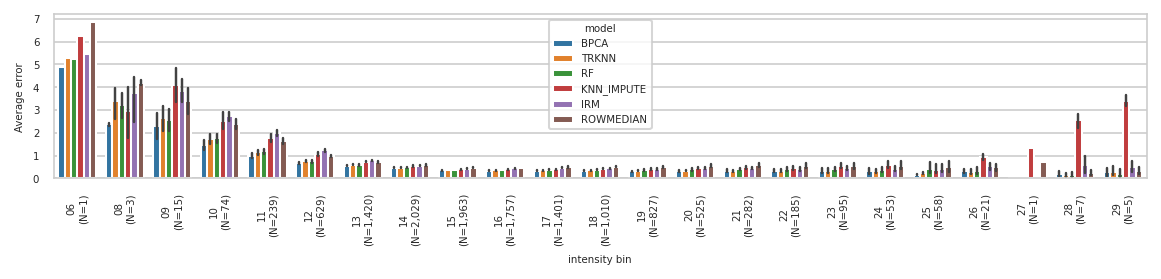

In [20]:
fig, ax = plt.subplots(figsize=(8, 2))
ax, errors_bind = vaep.plotting.errors.plot_errors_binned(
    val_pred_fake_na[top_5],
    ax=ax,
)
fname = args.out_figures / 'NAGuideR_errors_per_bin_val.png'
files_out[fname.name] = fname.as_posix()
vaep.savefig(ax.get_figure(), fname)

In [21]:
files_out

{'pred_val_BPCA.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_val_BPCA.csv',
 'pred_test_BPCA.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_test_BPCA.csv',
 'pred_real_na_BPCA.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_real_na_BPCA.csv',
 'pred_val_COLMEDIAN.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_val_COLMEDIAN.csv',
 'pred_test_COLMEDIAN.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_test_COLMEDIAN.csv',
 'pred_real_na_COLMEDIAN.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_real_na_COLMEDIAN.csv',
 'pred_val_IMPSEQ.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_val_IMPSEQ.csv',
 'pred_test_IMPSEQ.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_test_IMPSEQ.csv',
 'pred_real_na_IMPSEQ.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_real_na_IMPSEQ.csv',
 'pred_val_IMPSEQROB.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_val_IMPSEQROB.csv',
 'pred_test_IMPSEQROB.csv': 'runs/alzheimer_study_2023_11_v2/preds/pred_test_IMPSEQROB.csv',
 'pred_real_na_